In [1]:

import numpy
import pandas
from matplotlib import pyplot as plt


In [2]:

emb = pandas.read_parquet('embedding.parquet').set_index('time')
emb.shape


(7322, 1024)

In [35]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = emb
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)
X_pca.shape

(7322, 1024)

(0.0, 128.0)

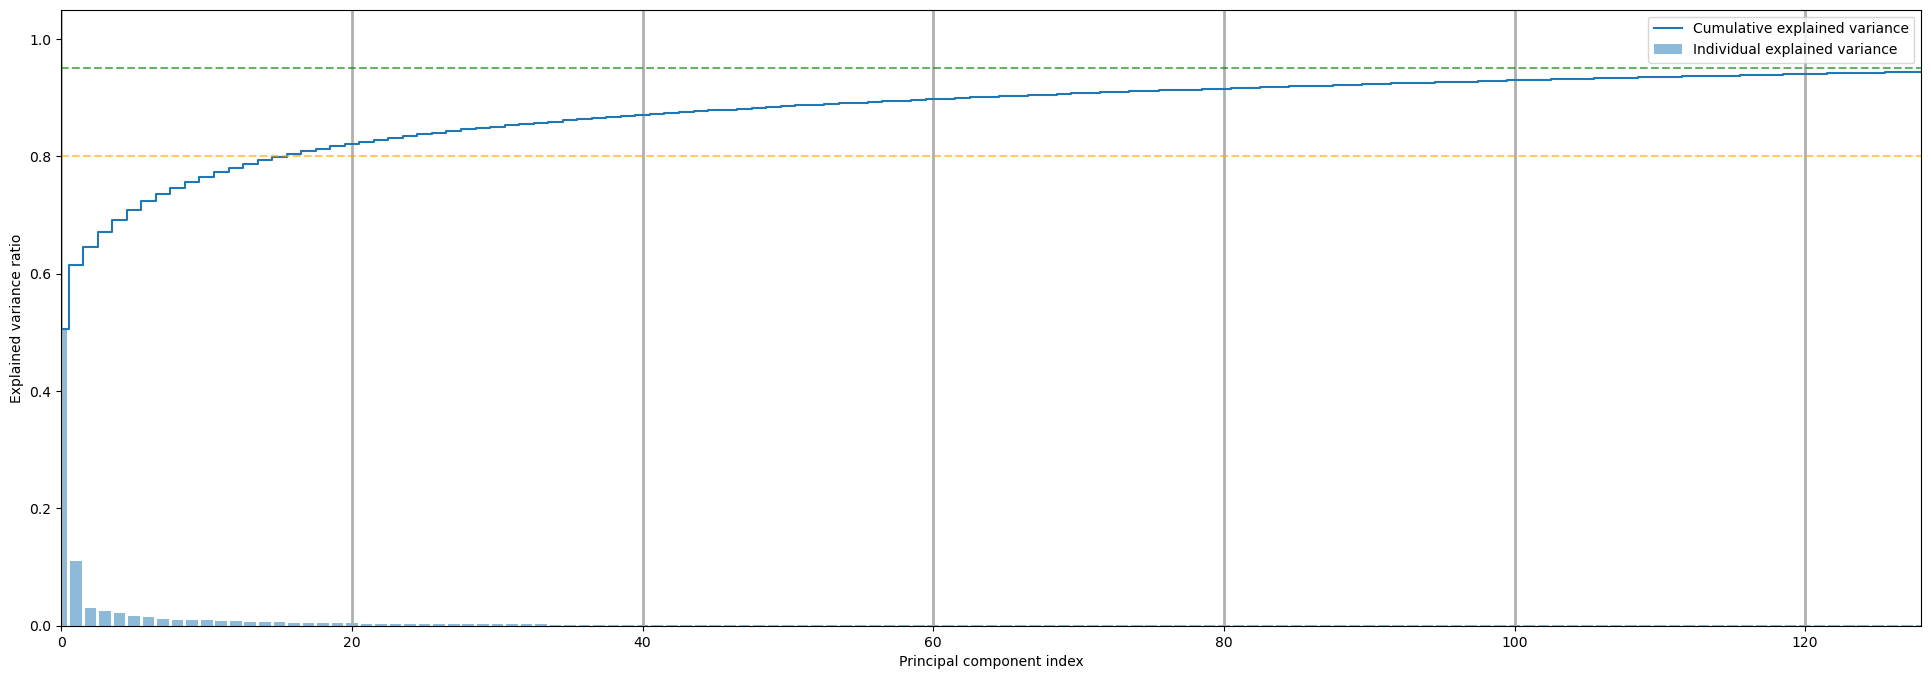

In [36]:
def plot_pca_variance(ax, pca):

    exp_var_pca = pca.explained_variance_ratio_

    cum_sum_eigenvalues = numpy.cumsum(exp_var_pca)
    
    ax.bar(range(0,len(exp_var_pca)), exp_var_pca,
           alpha=0.5,
           align='center',
           label='Individual explained variance')
    ax.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
            where='mid',
            label='Cumulative explained variance')
    ax.set_ylabel('Explained variance ratio')
    ax.set_xlabel('Principal component index')
    ax.legend(loc='best')
    ax.axhline(0.80, ls='--', alpha=0.6, color='orange')
    ax.axhline(0.95, ls='--', alpha=0.6, color='green')
    ax.grid(True, axis='x', lw=2.0) 

fig, ax = plt.subplots(1, figsize=(24,8))
plot_pca_variance(ax, pca)
ax.set_xlim(0, 128)

In [37]:
emb_pca = pandas.DataFrame(X_pca[:, 0:16], index=emb.index)
emb_pca.shape

(7322, 16)

In [38]:

# Try to segment using the embeddings
# TODO: perform clustering. AgglomerativeClustering
#cluster = sklearn.cluster.AgglomerativeClustering()

for eps in numpy.linspace(4.0, 5.0, 3):

    from sklearn.cluster import DBSCAN
    cluster = DBSCAN(eps=eps, min_samples=5)
    
    cluster.fit(emb_pca)
    emb_cluster = pandas.Series(cluster.labels_, index=emb_pca.index)
    print(eps, '\n', emb_cluster.value_counts())

# TODO: plot number of clusters and noise with changing hyperparameters

4.0 
 -1     7135
 1      100
 8       14
 0        9
 11       8
 4        7
 5        6
 12       6
 2        5
 7        5
 13       5
 3        5
 6        5
 10       5
 9        4
 14       3
dtype: int64
4.5 
 -1     6443
 1      753
 10      15
 0        9
 2        8
 7        8
 18       7
 20       6
 5        6
 4        5
 12       5
 19       5
 15       5
 6        5
 13       5
 11       5
 9        5
 8        5
 21       4
 3        4
 17       4
 16       4
 22       3
 14       3
dtype: int64
5.0 
 -1     5318
 1     1946
 0        9
 9        5
 13       5
 10       5
 5        4
 12       4
 7        4
 11       4
 2        3
 3        3
 8        3
 4        3
 14       3
 6        3
dtype: int64


In [39]:

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=6)
    
cluster.fit(emb_pca)
agg_cluster = pandas.Series(cluster.labels_, index=emb_pca.index)
print(agg_cluster.value_counts())


2    5113
4    1701
5     357
3      62
1      45
0      44
dtype: int64


In [45]:
agg

time,0.00,0.48,0.96,1.44,1.92,2.40,2.88,3.36,3.84,4.32,...,3509.76,3510.24,3510.72,3511.20,3511.68,3512.16,3512.64,3513.12,3513.60,3514.08
0,1,1,1,1,1,1,1,1,1,1,...,2,0,0,1,1,0,3,3,3,2


pp 6


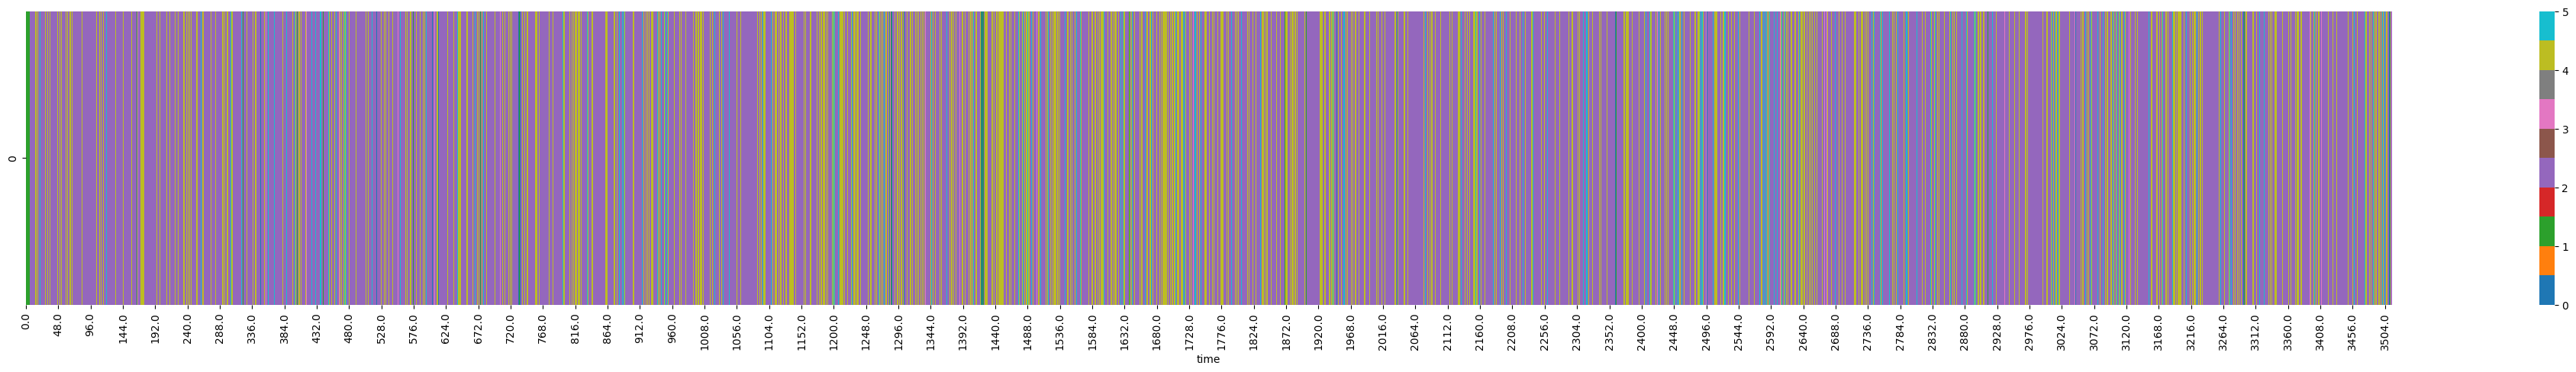

In [48]:
import seaborn

def plot_mapping(labeled, palette = 'tab10'):
    fig, ax = plt.subplots(1, figsize=(50, 5))

    print('pp', labeled.nunique())
    colors = seaborn.color_palette(palette)
    color = colors[0:labeled.nunique()]

    df = labeled.to_frame().T
    seaborn.heatmap(df, ax=ax, cmap=colors, xticklabels=100)


plot_mapping(agg_cluster)

In [76]:


def read_labels(path):
    labels = pandas.read_csv(path, sep='\t', header=None,
                            names=['start', 'end', 'annotation'],
                            dtype=dict(start=float,end=float,annotation=str))
    return labels

labels = read_labels('Conference_speakers.txt')
labels.head()


,start,end,annotation
0,4.005756,167.682063,Trym
1,169.743900,312.949668,Morten
2,313.678120,603.579771,Oystein
3,604.842930,613.474521,Alexa
4,615.579787,732.000998,Oystein


In [77]:
labels.annotation.value_counts()

Morten     31
Oystein    13
Jon         9
Audun       6
Iver        3
Trym        1
Alexa       1
Name: annotation, dtype: int64

In [100]:
labels = labels[~labels.annotation.isin(['Trym', 'Alexa', 'Iver'])] # remove tiny classes
labels.annotation.value_counts()

Morten     31
Oystein    13
Jon         9
Audun       6
Name: annotation, dtype: int64

In [101]:
def label_timeseries(timeseries, labels, label_column='label'):
    """
    NOTE: assumes a single label per time period
    """
    
    df = timeseries.copy()
    for start, end, label in zip(labels.start, labels.end, labels.annotation):
        df.loc[start:end, label_column] = label

    return df

emb_labeled = label_timeseries(emb, labels=labels)
emb_labeled.label.value_counts(dropna=False)

Morten     1816
Jon        1757
Oystein    1647
Audun      1317
NaN         785
Name: label, dtype: int64

In [250]:
def undersample(df, class_column='label'):
    
    classes = df[class_column].value_counts().to_dict()
    least_class_amount = min(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df[class_column] == key]) 
    classes_sample = []
    
    for i in range(0,len(classes_list)-1):
        classes_sample.append(classes_list[i].sample(least_class_amount))

    df_maybe = pandas.concat(classes_sample)
    final_df = pandas.concat([df_maybe, classes_list[-1]], axis=0)
    #final_df = final_df.reset_index(drop=True)
    return final_df

undersample(train_data).label.value_counts()

Jon        591
Audun      591
Oystein    591
Morten     591
Name: label, dtype: int64

In [251]:
# prepare dataset
test_split_time = 1900.0 # after this there is a panel

data = emb_labeled.copy()
data = data.dropna(subset=['label']) # drop areas without annotations

feature_columns = data.columns[(data.columns.str.startswith('e'))]

train_data = data.loc[0:test_split_time]

train_data = undersample(train_data)

test_data = data.loc[test_split_time:]


X_train = train_data[feature_columns]
y_train = train_data['label']

X_test = test_data[feature_columns]
y_test = test_data['label']

print('train')
print(y_train.value_counts())
print('test')
print(y_test.value_counts())

train
Jon        591
Audun      591
Oystein    591
Morten     591
Name: label, dtype: int64
test
Morten     1225
Oystein     739
Jon         692
Audun       322
Name: label, dtype: int64


In [262]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import sklearn.metrics

estimator = make_pipeline(
    StandardScaler(),
    PCA(32),
    KNeighborsClassifier(32),
    #DummyClassifier(),
)

# TODO: balance out the different speakers in training set
# TODO: see what happens with performance as we reduce training set size. Run multiple experiments per size, random samples

scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score, average = 'macro')
scores = cross_val_score(estimator=estimator, X=X_train, y=y_train, scoring=scorer)
estimator.fit(X_train, y_train) # re-fit entire dataset

scores

array([0.74490049, 0.71306091, 0.71428642, 0.7560031 , 0.71029059])

In [263]:
scorer(estimator, X_test, y_test)

0.6067729332900125

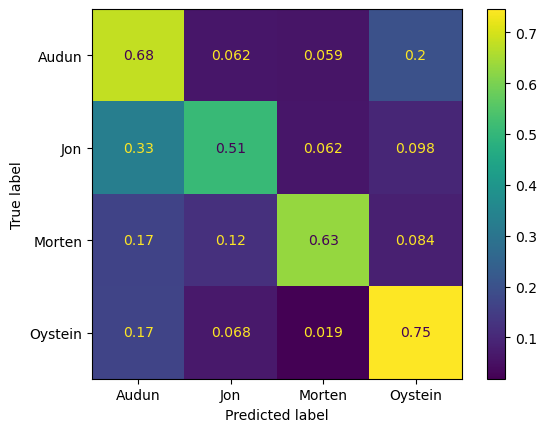

In [264]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, normalize='true')

In [255]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

pred = estimator.predict(X_test)
pred = pandas.Series(pred, index=test_data.index, name='label').to_frame()
pred

,label
time,
1900.32,Jon
1900.80,Jon
1901.28,Oystein
1901.76,Oystein
1902.24,Oystein
...,...
3508.80,Oystein
3509.28,Audun
3509.76,Jon


In [256]:
def predict_proba(estimator, data):
    """
    predict_proba with proper pandas.DataFrame support
    """

    X = data[feature_columns] # XXX: global
    pp = estimator.predict_proba(X)
    df = pandas.DataFrame(pp, index=data.index, columns=estimator.classes_)

    return df

pp = predict_proba(estimator, test_data)
pp

,Audun,Jon,Morten,Oystein
time,,,,
1900.32,0.15625,0.46875,0.37500,0.00000
1900.80,0.25000,0.43750,0.18750,0.12500
1901.28,0.18750,0.18750,0.06250,0.56250
1901.76,0.18750,0.25000,0.03125,0.53125
1902.24,0.18750,0.25000,0.03125,0.53125
...,...,...,...,...
3508.80,0.25000,0.15625,0.18750,0.40625
3509.28,0.37500,0.12500,0.34375,0.15625
3509.76,0.34375,0.40625,0.12500,0.12500


In [257]:
def temporal_smoothing(df, lookback='3s', agg='median'):
    lookback = pandas.Timedelta(lookback)
    
    df = df.sort_index()

    df.index = pandas.to_timedelta(df.index, unit='s')

    out = df.copy()
    for end in df.index:
        start = max(end - lookback, df.index.min())
        #print('s', start, end)
        window = out.loc[start:end]
        out.loc[end] = window.agg(agg, axis=0)

    out.index = out.index.total_seconds()
    
    return out

ll = temporal_smoothing(pp, lookback='4s', agg='mean')
ll.head(20)
    

,Audun,Jon,Morten,Oystein
time,,,,
1900.32,0.156250,0.468750,0.375000,0.000000
1900.80,0.203125,0.453125,0.281250,0.062500
1901.28,0.182292,0.369792,0.239583,0.208333
1901.76,0.182292,0.385417,0.231771,0.200521
1902.24,0.182292,0.385417,0.231771,0.200521
1904.16,0.192708,0.395833,0.294271,0.117188
1904.64,0.177951,0.357639,0.332899,0.131510
1905.12,0.163339,0.388600,0.294633,0.153429
1905.60,0.186222,0.360484,0.288182,0.165111


In [258]:
# FIXME: make this into a function
class_map_idx = dict(zip(range(0, 4), estimator.classes_))
class_map_idx

llp = ll.values.argmax(axis=1)

smooth = pandas.Series(llp, index=ll.index).replace(class_map_idx)
smooth.value_counts()

Morten     988
Oystein    823
Audun      691
Jon        476
dtype: int64

In [269]:
sklearn.metrics.f1_score(y_true=y_test, y_pred=pred, average = 'macro')

0.6078232572579312

In [270]:
sklearn.metrics.f1_score(y_true=y_test, y_pred=smooth, average = 'macro')


0.7039670671730226

In [259]:
# TODO: also add/try HMM-GMM smoothing



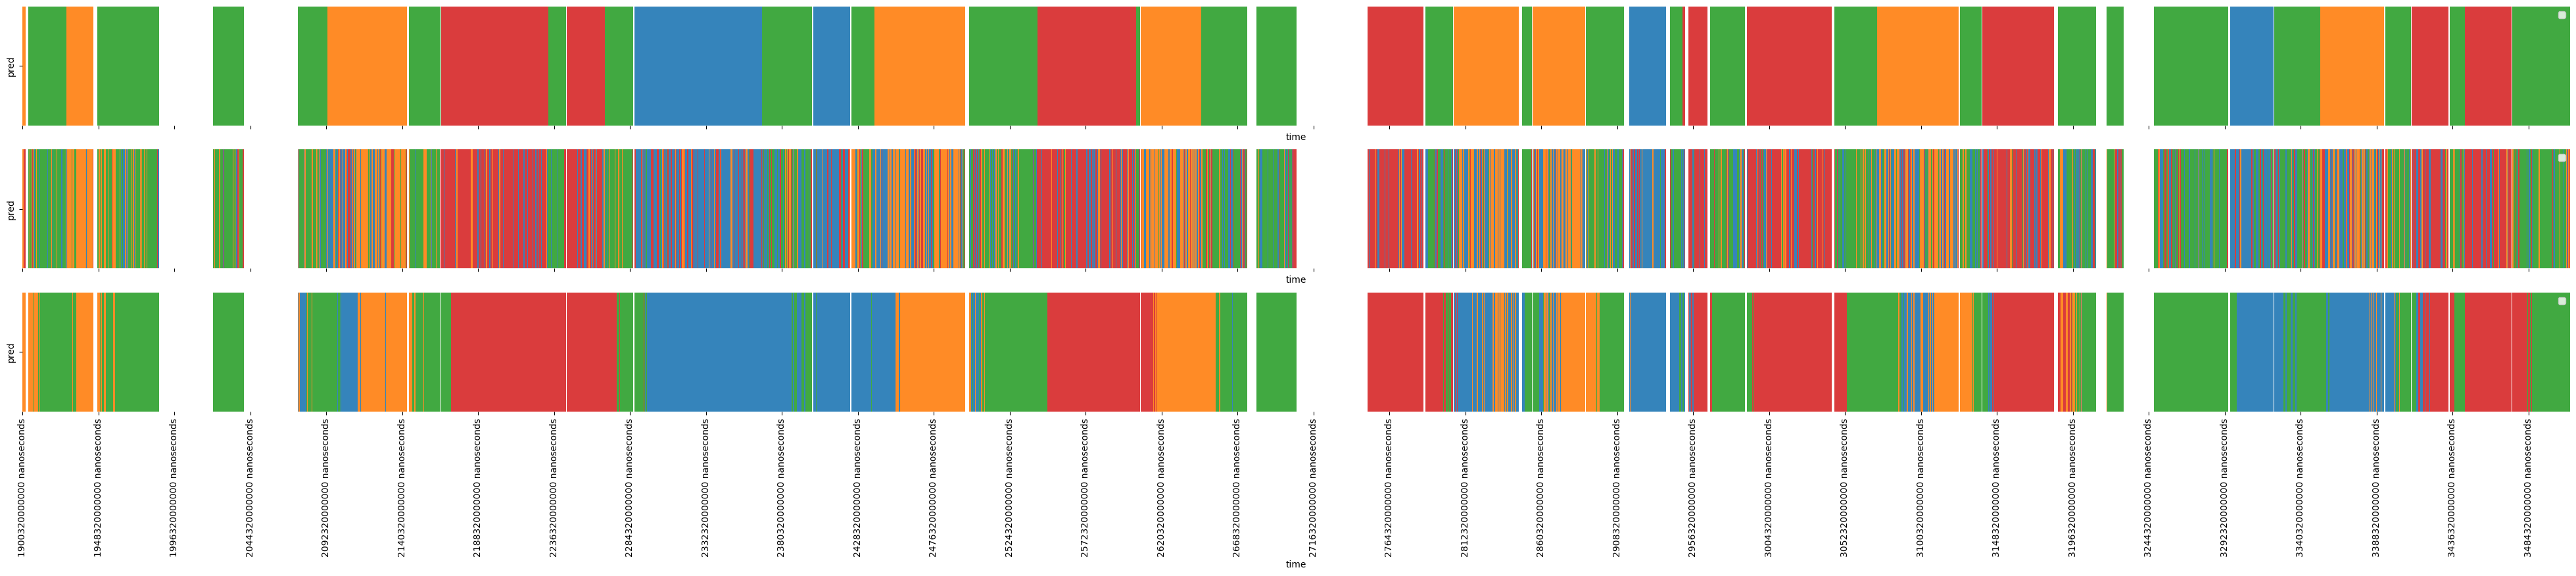

In [260]:

def plot_mapping(ax, labeled, palette = 'tab10'):
    
    colors = seaborn.color_palette(palette)
    colors = colors[0:labeled.nunique()]

    # TODO: support categorical names for labels, not just indices
    enc = LabelEncoder()
    labeled = pandas.Series(enc.fit_transform(labeled), index=labeled.index)
    
    # handle holes in the input data
    hop_duration = 0.480
    full_times = numpy.arange(labeled.index.min(), labeled.index.max(), hop_duration)
    full = pandas.DataFrame({ 'time': pandas.to_timedelta(full_times, unit='s'), 'pred': None }).set_index('time')
    df = labeled.copy()
    df.index = pandas.to_timedelta(df.index, unit='s')
    full['pred'] = df

    
    df = full.T
    seaborn.heatmap(df, ax=ax, cmap=colors, xticklabels=100, cbar=False, alpha=0.9)

    # FIXME: add a legend with labels
    labels = enc.inverse_transform(range(len(colors)))
    ax.legend(labels=labels)


fig, (ref_ax, pred_ax, smooth_ax)  = plt.subplots(3, figsize=(50, 8), sharex=True)

plot_mapping(ref_ax, test_data['label'])
plot_mapping(pred_ax, pred['label'])
plot_mapping(smooth_ax, smooth)


In [196]:

# TODO: try to learn a simple RNN

def build_rnn(timesteps, n_classes,
              embedding_size=1024, embedding_reduce=128, rnn=10):

    from tensorflow.keras import layers as l
    from tensorflow.keras import Sequential
                  
    model = Sequential([
        l.Input(shape=(timesteps, embedding_size)),
        l.TimeDistributed(l.Dense(embedding_reduce)),
        l.Bidirectional(l.GRU(rnn, return_sequences=True)),
        l.Bidirectional(l.GRU(rnn, return_sequences=True)),
        l.TimeDistributed(l.Dense(n_classes)),
        l.Activation('sigmoid'),
    ])

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

m = build_rnn(5, n_classes=4, embedding_size=1024, embedding_reduce=16, rnn=16)
m.summary()

2023-06-03 20:17:12.668723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 20:17:12.669627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 20:17:12.670598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 5, 16)            16400     
 stributed)                                                      
                                                                 
 bidirectional_16 (Bidirecti  (None, 5, 32)            3264      
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 5, 32)            4800      
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 5, 4)             132       
 stributed)                                                      
                                                                 
 activation_8 (Activation)   (None, 5, 4)             

2023-06-03 20:17:12.881672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-03 20:17:12.883005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-03 20:17:12.883895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:

y_train


In [198]:

m.fit(X_train, y_train)


ValueError: in user code:

    File "/home/jon/.local/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/jon/.local/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jon/.local/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/jon/.local/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/jon/.local/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jon/.local/lib/python3.11/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 5, 1024), found shape=(None, 1024)
